

# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [198]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd
import datetime as dt
%matplotlib inline

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
from sklearn import preprocessing

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
#pl.rcParams['font.size'] = 20
#Image(filename = "Ridetypes.png")

%pylab inline

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


This is the information I recieved about the data: "each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as

np.load(“MTA_Fare.npy") and

you will end up with a python numpy array of shape (600,23,194)

note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans: np.nanmean np.nansum...

# HINTS:
notes and hints:
1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array

2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc

np.nanmean(mtarides)
np.nansum(mtarides)
as opposed to just

np.mean(mtarides)
np.sum(mtarides)
### There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations.
When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - np.average(....weight=...) -. The sum and average functions take an axis argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.

## Possibly useful functions
You are already familiar with and have already used most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient
the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...
the array methods
np.array.flatten()
np.array.reshape()
allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
mtaarray.flatten()
which returns the flatten array:

mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
`

## Read in data as instructed above

In [7]:
#Reading Data 
mta = np.load('MTA_Fare.npy').astype(float)

In [8]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)
mta[mta==-1]=np.nan

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [9]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. After that I create a date range (for example with pd.date_range()) in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i])) all time series, each station each ride type, look like this (pretty ugly)

In [10]:
#May 19, 2010 - Friday Feb 19, 2014 - Friday
dates = pd.date_range(start='05/19/2010', periods=194, freq='W')


In [11]:
dates

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.

In [12]:
np.nansum(mta,axis=0).shape

(23, 194)

In [13]:
np.nansum(mta,axis=1).shape

(600, 194)

In [14]:
# Sum per week
countPerCardType = np.nansum(mta,axis=0)
countPerStation = np.nansum(mta,axis=1)

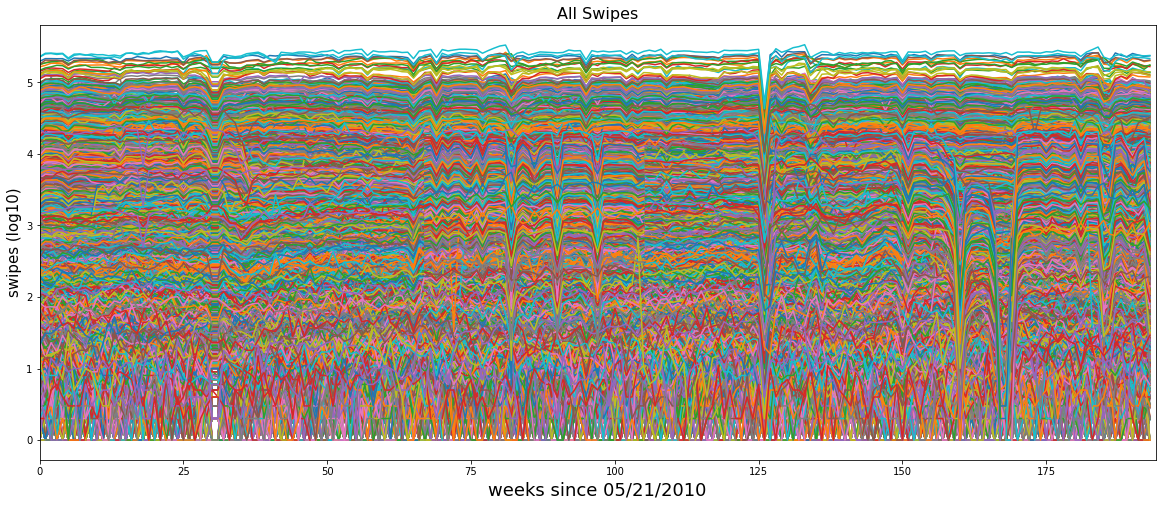

In [273]:
# plot the each swipe per each station per each week
pl.figure(figsize=(20,8))
for i in range(mta.shape[1]):
    pl.plot(np.log10(mta[:,i].T))
    
pl.title("All Swipes", fontsize=16)
pl.xlabel("weeks since 05/21/2010", fontsize=18)
pl.ylabel("swipes (log10)", fontsize=15)
pl.xlim(0, 194)
pl.show()

##### Figure 1. Reflects a time seriers of the all ridership type and all station using log10 space 

## 1: event detection
##### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what may have caused this event

In [274]:
countPerStation.shape

(600, 194)

In [275]:
# Sum per week
allStations = np.nansum(countPerStation,axis=0)
allStations.shape

(194,)

In [276]:
allStations = pd.DataFrame({'Frequency' : allStations.T}, index = dates)
allStations.head()

,Frequency
2010-05-23,26720267.0
2010-05-30,29265971.0
2010-06-06,29601189.0
2010-06-13,29387592.0
2010-06-20,29185768.0


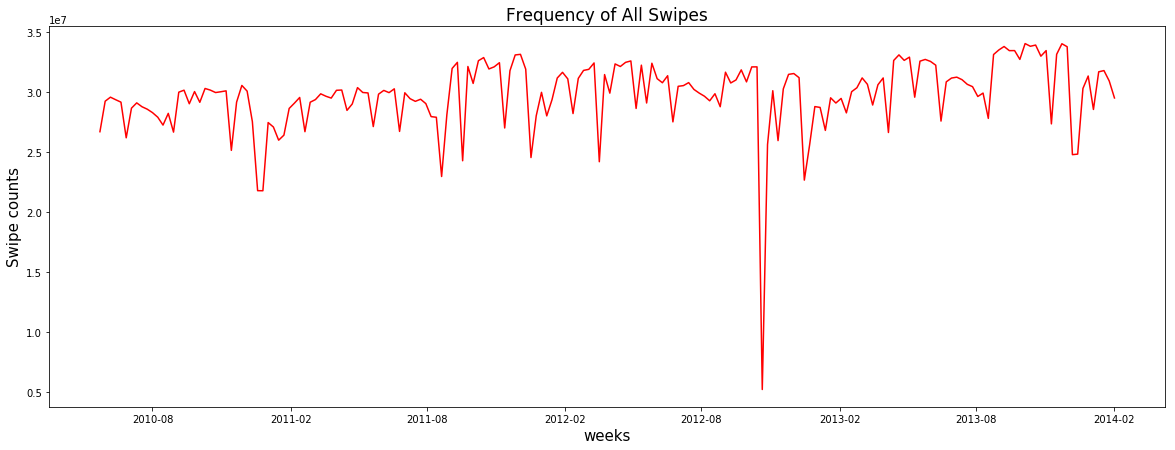

In [277]:
plt.figure(figsize=(20,7))
plt.plot(allStations, c='r')
plt.title("Frequency of All Swipes", fontsize=17)
plt.xlabel("weeks", fontsize=15)
plt.ylabel("Swipe counts", fontsize=15)

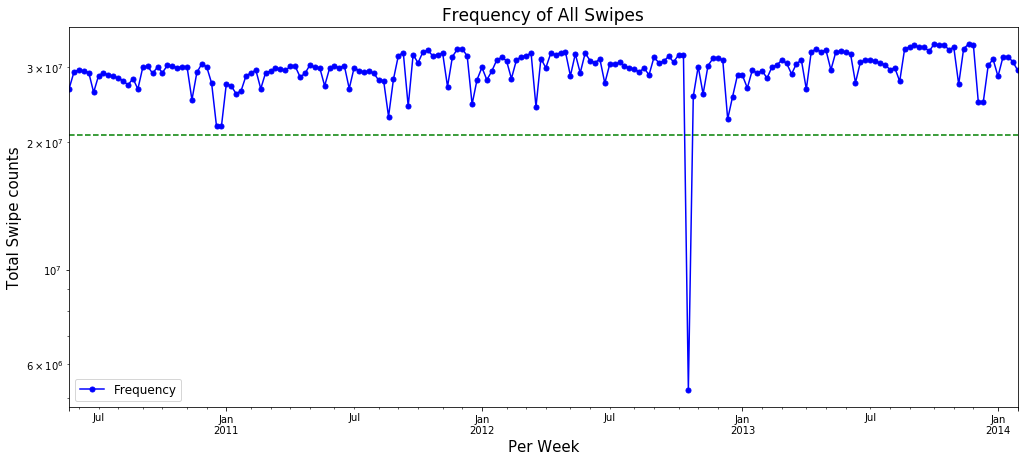

In [278]:
ax = allStations.plot(logy=True, figsize=(17,7), style=".-", ms=10, color="blue")
#treshold
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]], 'g--')
plt.title("Frequency of All Swipes", fontsize=17)
plt.legend(fontsize=12, loc='lower left')
# plt.ylim
plt.xlabel("Per Week", fontsize=15)
plt.ylabel("Total Swipe counts", fontsize=15)
plt.show()


Figure 3. Indicates the sum of every card swipes, with the mean of every station

In [223]:
minmta1 = allStations.loc[(allStations.Frequency < thresholds[1])]
minmta1

,Frequency
2012-10-21,5218686.0


## Identify the most prominent event
At 125 weeks a deep drop can be seen which is 2017-10-26 when Hurricane Sandy comes. So that's why a big drop.

## 2: finding trends
## NOTE ON THE TREND DETECTION:
###### you should find the ride type that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend
###### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type.
##### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the number of rides near the beginning to the number of rides near the end of the time series.
##### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of th

In [284]:
cardtype=np.nansum(mta,axis=0)

In [285]:
cardtype.shape

(23, 194)

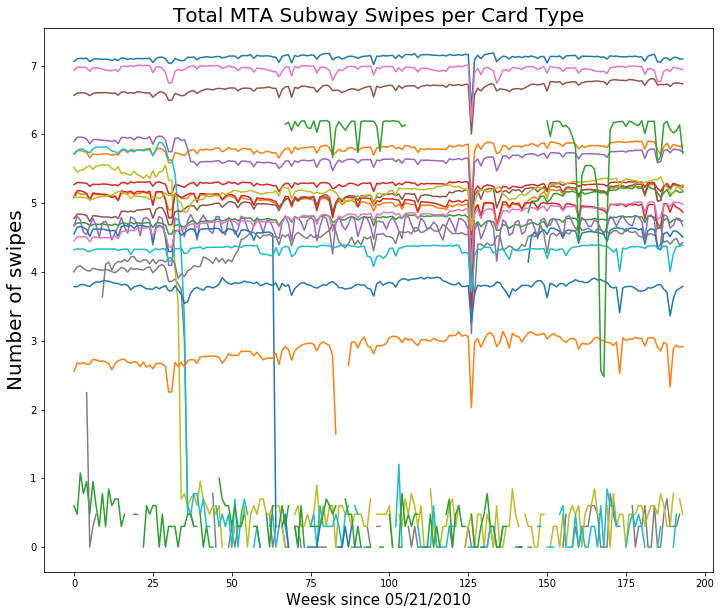

In [292]:
pl.figure(figsize=(12,10))
for i in range(len(cardtype)):
    pl.plot(np.log10(cardtype[i]))
pl.xlabel("Weesk since 05/21/2010",fontsize=15)
pl.ylabel("Number of swipes",fontsize=20)
title("Total MTA Subway Swipes per Card Type", fontsize=20);

##### Figue 2. overview of all swipe per week; between August- February 

In [224]:
popMean = np.nanmean(allStations)
popStd = np.nanstd(allStations)

print("Mean: {:.4f}".format(popMean))
print("Standard Deviation: {:.4f}".format(popStd))

Mean: 29781349.8711
Standard Deviation: 2983960.4217


In [225]:
thresholds = [popMean + 3 * popStd, 
              popMean - 3 * popStd]
print("Thresholds (3std): {}".format(thresholds))

Thresholds (3std): [38733231.136236683, 20829468.606031362]


# Task 2: 
##### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [294]:
#Counter per card type into DF
cardtype = pd.DataFrame(countPerCardType.T)
cardtype.set_index(dates, inplace=True)
cardtype.columns = ridetype

In [295]:
cardtype.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
2010-05-23,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
2010-05-30,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0
2010-06-06,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,0.0
2010-06-13,12653675.0,562602.0,52063.0,196389.0,37429.0,4032753.0,9450081.0,11221.0,305513.0,606270.0,...,147094.0,902549.0,68099.0,32404.0,0.0,122051.0,21630.0,6590.0,484.0,0.0
2010-06-20,12809694.0,548858.0,51153.0,194883.0,35210.0,3925446.0,9294002.0,10515.0,335780.0,563446.0,...,137888.0,855573.0,66377.0,31933.0,176.0,119776.0,20297.0,6313.0,452.0,0.0


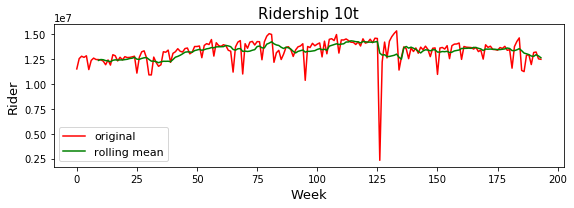

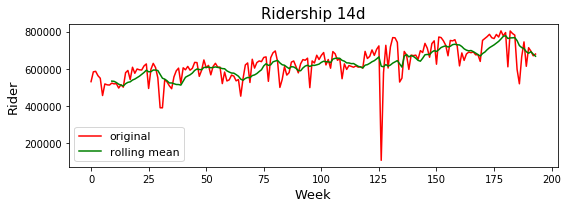

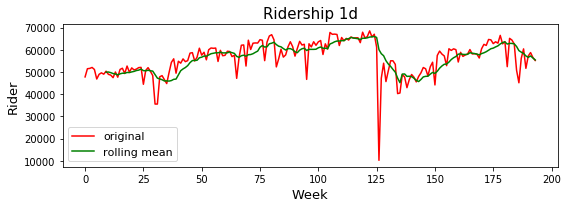

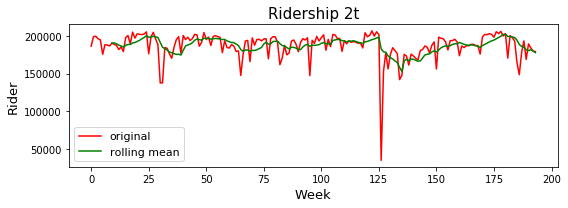

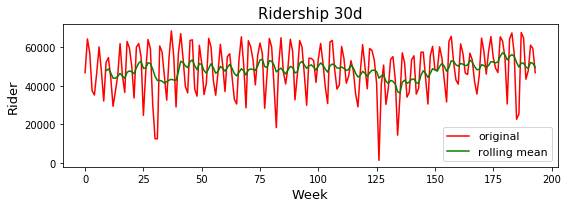

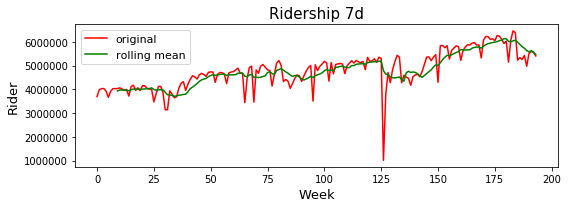

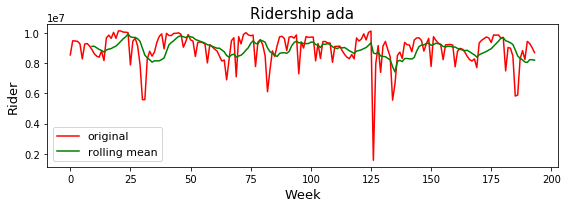

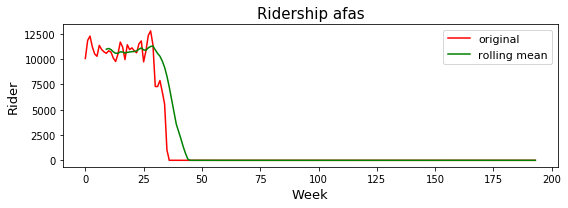

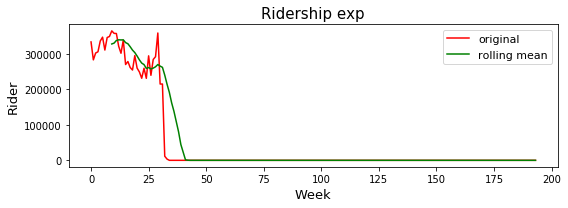

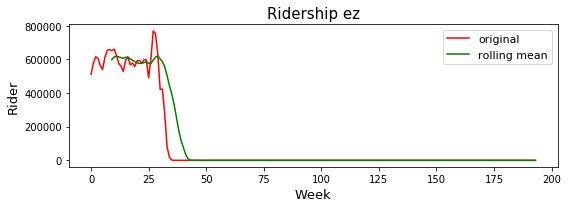

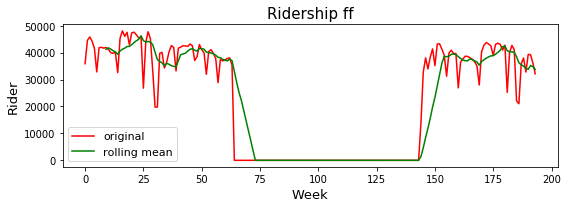

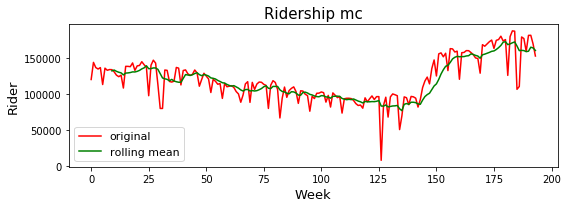

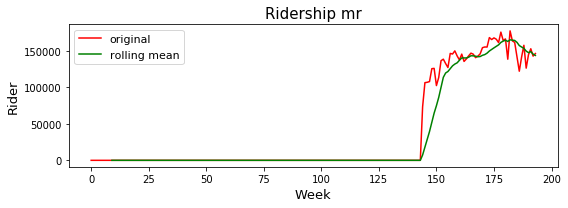

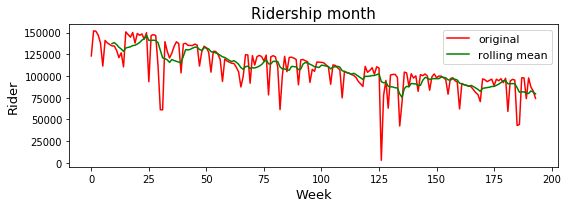

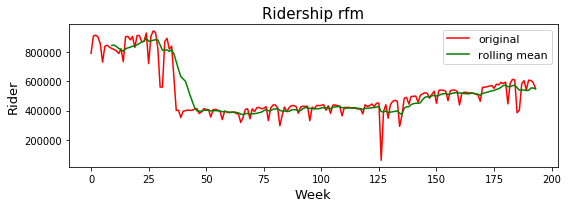

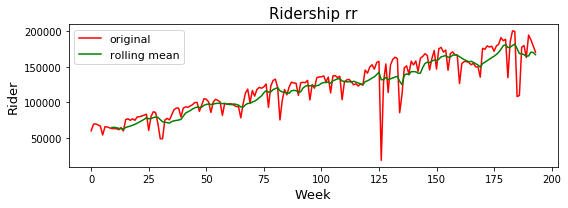

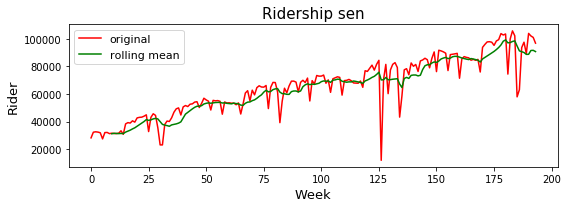

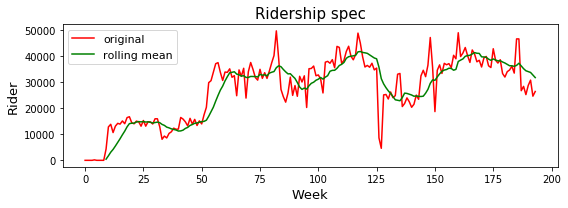

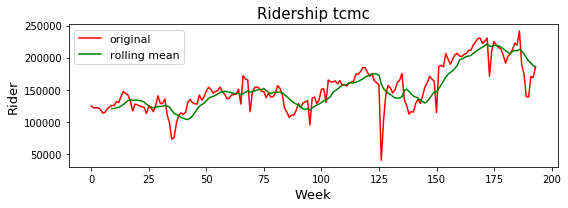

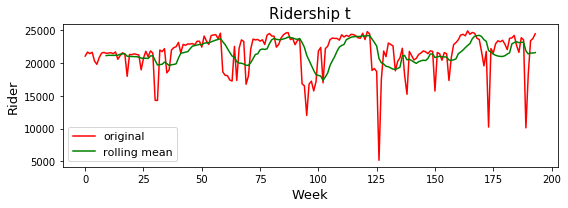

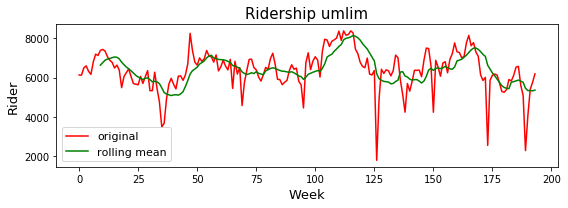

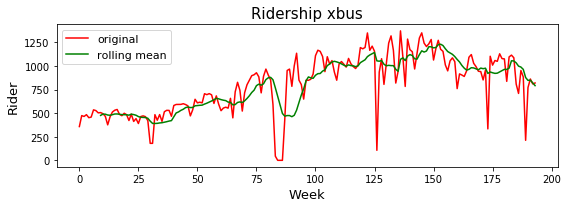

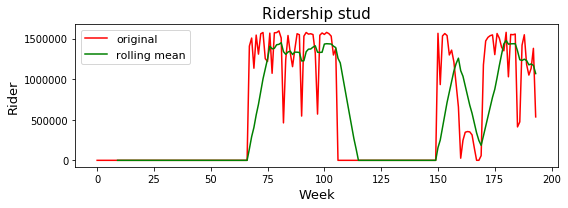

In [311]:
for i in cardtype.keys():
    plt.figure(figsize=(8,3))
    #rolling mean, window 10
    cardrmean = cardtype[i].rolling(window=10).mean()
    plt.plot(np.arange(len(cardtype[i])), cardtype[i], label="original", c='red')
    plt.plot(np.arange(len(cardtype[i])), cardrmean, label="rolling mean", c='green')
    plt.title("Ridership {}".format(i), fontsize=15)
    plt.ylabel("Rider", fontsize=13)
    plt.xlabel("Week", fontsize=13)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

## Figure 4: Time seriers plot based on card type 

In [343]:
for i in range(len(mtatype)):
    ratio=(np.nansum(mtatype[i][184:194])-np.nansum(mtatype[i][0:10]))/np.nansum(mtatype[i][0:10])
    std = np.nanstd(mtatype[i])
    print(i+1)
    print('stdev %.2f, fractional change over time: %.2f'%(std,ratio))

1
stdev 1212509.30, fractional change over time: 0.02
2
stdev 90631.59, fractional change over time: 0.25
3
stdev 7599.23, fractional change over time: 0.11
4
stdev 17590.59, fractional change over time: -0.07
5
stdev 12633.84, fractional change over time: 0.03
6
stdev 763049.86, fractional change over time: 0.39
7
stdev 1053449.59, fractional change over time: -0.10
8
stdev 4061.96, fractional change over time: -1.00
9
stdev 110873.91, fractional change over time: -1.00
10
stdev 221304.42, fractional change over time: -1.00
11
stdev 19630.51, fractional change over time: -0.18
12
stdev 29656.86, fractional change over time: 0.21
13
stdev 63142.33, fractional change over time: 24783.93
14
stdev 23741.91, fractional change over time: -0.42
15
stdev 171277.60, fractional change over time: -0.35
16
stdev 38211.21, fractional change over time: 1.59
17
stdev 20717.30, fractional change over time: 1.91
18
stdev 12072.61, fractional change over time: 69.18
19
stdev 34885.92, fractional change

## 3. Build models that classified the ride type based on the time series characteristics using random forests.
Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model

## Build one that uses as input features the following engineered features :
the time series mean divided by the mean of all time series for that station
the time series standard deviation by the standard deviation of all time series for that station
the slope and intercept of a line fit to the standardized time series
  (time_series - time_series.mean())/time_series.std()

In [71]:
mta.shape

(600, 23, 194)

In [233]:
mta_ridership = mta.reshape(600*23,194)
mta_sta= mta.reshape(600*23,194)


In [234]:
#time series standard deviation divided by the standard deviation of that station
ridestd_norm = []
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        std = np.nanstd(mta_ridership[j])/mta_sta[i]
        ridestd_norm.append(std)
ridestd_norm = np.asarray(ridestd_norm)
ridestd_norm[:10]

array([[ -1.09239506e+01,   2.90398288e+00,   1.88644460e+00, ...,
         -8.05130748e-01,  -7.20300696e-01,  -8.16118437e-01],
       [ -5.59635667e+03,   1.48771488e+03,   9.66428461e+02, ...,
         -4.12469717e+02,  -3.69011152e+02,  -4.18098728e+02],
       [ -7.28689239e+02,   1.93712068e+02,   1.25836515e+02, ...,
         -5.37067706e+01,  -4.80481268e+01,  -5.44397116e+01],
       ..., 
       [ -2.05196700e+02,   5.45487365e+01,   3.54351846e+01, ...,
         -1.51236653e+01,  -1.35302082e+01,  -1.53300592e+01],
       [ -2.53534970e+04,   6.73988045e+03,   4.37826654e+03, ...,
         -1.86863532e+03,  -1.67175248e+03,  -1.89413675e+03],
       [ -1.08628432e+04,   2.88773829e+03,   1.87589201e+03, ...,
         -8.00626927e+02,  -7.16271406e+02,  -8.11553152e+02]])

In [235]:

#time series mean divided by the mean of that station
ridemeans_norm = []
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        mean = np.nanmean(mta_ridership[j])/mta_sta[i]
        ridemeans_norm.append(mean)
ridemeans_norm = np.asarray(ridemeans_norm)
ridemeans_norm[:10]

array([[ -8.10648588e-16,   2.15499841e-16,   1.39989982e-16, ...,
         -5.97474417e-17,  -5.34523417e-17,  -6.05628202e-17],
       [ -2.00231849e+04,   5.32288986e+03,   3.45778100e+03, ...,
         -1.47577395e+03,  -1.32028371e+03,  -1.49591397e+03],
       [ -2.59928163e+03,   6.90983472e+02,   4.48866984e+02, ...,
         -1.91575523e+02,  -1.71390775e+02,  -1.94189971e+02],
       ..., 
       [ -9.38949558e+01,   2.49606899e+01,   1.62146130e+01, ...,
         -6.92036411e+00,  -6.19122187e+00,  -7.01480693e+00],
       [ -1.07024848e+04,   2.84510921e+03,   1.84819991e+03, ...,
         -7.88807992e+02,  -7.05697736e+02,  -7.99572923e+02],
       [ -4.72361222e+03,   1.25570771e+03,   8.15715216e+02, ...,
         -3.48145608e+02,  -3.11464349e+02,  -3.52896782e+02]])

In [238]:

#calculate the standard deviation of each station
mta_sta = []
for i in range(len(mta)):
    std = np.nanstd(mta[i])
    mta_sta.append(std)
mta_sta = np.asarray(mta_sta)
mta_sta.shape

(600,)

In [249]:
#apply the label
AR = np.asarray([np.arange(0,mta.shape[1])]*mta.shape[0]).flatten() 
AR[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22,  0,  1,  2])

In [250]:
df = pd.DataFrame(np.transpose([label]))
df.rename(columns={0:'cardtype'}, inplace=True)
df.shape

(13800, 1)

In [252]:
total_df1 = pd.merge(label_df, pd.DataFrame(mta_ridership), left_index=True, right_index=True)
total_df1.dropna(inplace=True)
total_df1.head()

,cardtype,0,1,2,3,4,5,6,7,8,...,184,185,186,187,188,189,190,191,192,193
46,0,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,2888.0,...,3506.0,2894.0,2679.0,3337.0,3599.0,3273.0,3418.0,3746.0,3406.0,3217.0
47,1,110.0,92.0,102.0,79.0,93.0,74.0,72.0,92.0,97.0,...,192.0,167.0,160.0,180.0,204.0,166.0,191.0,212.0,209.0,211.0
48,2,7.0,6.0,13.0,7.0,5.0,7.0,7.0,6.0,3.0,...,21.0,17.0,18.0,20.0,19.0,13.0,19.0,26.0,20.0,22.0
49,3,41.0,51.0,47.0,37.0,50.0,43.0,44.0,32.0,43.0,...,25.0,18.0,24.0,20.0,25.0,29.0,31.0,28.0,24.0,22.0
50,4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2.0,1.0,1.0,10.0,8.0,6.0,5.0,5.0,6.0,0.0


In [253]:
total_df1.shape

(9174, 195)

In [257]:
AR=total_df1['cardtype'] 

In [259]:
mtatotalrs = total_df1.drop(['cardtype'], axis=1)

In [284]:
mtatotalrs .dropna(inplace=True)
mtatotalrs 
mtatotalrs .reset_index(inplace=True, drop=True)
mtatotalrs  =mtatotalrs .T
mtatotalrs .shape

(9174, 194)

In [285]:
# Mean and Std. Deviation of each time series (i.e., 194) for each station
#mta_ridership['mean_ts'] = mta_ridership.mean(axis=1)
#mta_ridership['std_ts'] = mta_ridership.std(axis=1)

tmean = np.nanmean(mean_ts, axis=1)
tstd = np.nanstd(std_ts, axis=1)


In [286]:
tmean.shape

(600,)

In [287]:
tmean[:10]

array([           nan,            nan,   314.8814433 ,   793.87183693,
         893.42408622,   980.43580131,   608.38308341,   541.54896907,
         500.86574508,  8644.11176195])

In [288]:
tstd[:10]

array([           nan,            nan,   100.4789314 ,   247.27663285,
         263.24624484,   299.74763967,   179.7563922 ,   174.06196985,
         161.53152016,  3497.62383672])

In [289]:
for i in range(mean_ts.shape[0]):
    mtatotalrs .T[i] = mtatotalrs .T[i].apply(lambda x: (x-totmean[i])/mean_ts[i])

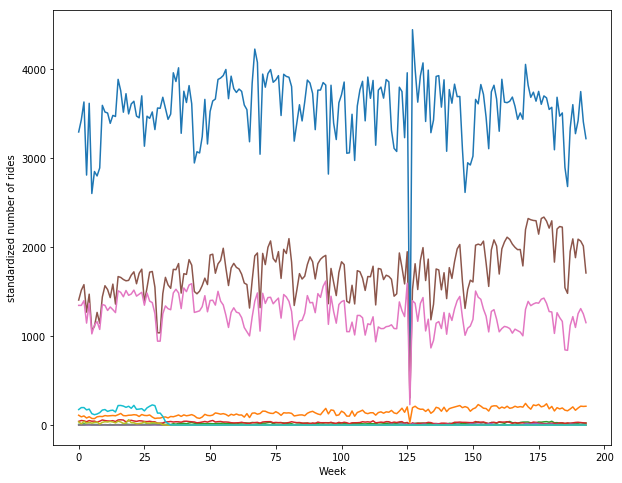

In [292]:
plt.figure(figsize=(10,8))
for i in range(10):
    plt.plot(mtatotalrs.T[i])
plt.xlabel('Week')
plt.ylabel('standardized number of rides')

Figure 5 reflicts the standaredized number of swipes 

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [100]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6242, 4), (3075, 4), (6242,), (3075,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [80]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(1, 0, 0, 0)

In [101]:
X_train[~np.isfinite(X_train)] = # ... make a choice about what to do with this datapoint. drop it or replace it with something

In [105]:
clf = rfc()...

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

and use sklearn confusion_matrix to see the errors

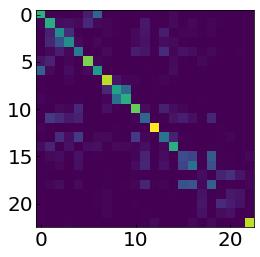

In [84]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [87]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    ...

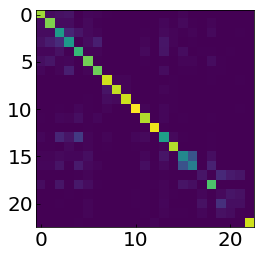

In [90]:
imshow(confusion_matrix(y_test, y_pred))

In [91]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.75      0.82      0.78       160
        14d       0.75      0.79      0.77       157
         1d       0.50      0.60      0.55       141
         2t       0.55      0.54      0.55       154
        30d       0.59      0.73      0.65       142
         7d       0.71      0.79      0.74       154
        ada       0.82      0.81      0.81       149
       afas       0.88      0.95      0.92       150
        exp       0.96      0.92      0.94       153
         ez       0.97      0.92      0.95       154
         ff       0.96      0.92      0.94       168
         mc       0.82      0.87      0.84       157
         mr       0.97      0.99      0.98       152
      month       0.57      0.55      0.56       159
        rfm       0.88      0.90      0.89       151
         rr       0.53      0.48      0.50       151
        sen       0.55      0.40      0.46       162
       spec       0.39      0.17      0.24   